In [1]:
from collections import defaultdict
import json

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
import pylab

#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
#Instruction3: Import your dataset and print then number of rows and columns
import pandas as pd
df=pd.read_csv("hour.csv")
print(len(df.columns))
print(len(df.index))
df.head(7)

20
17379


instant    dteday  season  yr  mnth  hr  holiday  weekday  workingday  weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  Start  End  Duration
0        1  1/1/2011       1   0     1   0        0        6           0           1  0.24  0.2879  0.81     0.0000       3          13   16    NaN  NaN       NaN
1        2  1/1/2011       1   0     1   1        0        6           0           1  0.22  0.2727  0.80     0.0000       8          32   40    NaN  NaN       NaN
2        3  1/1/2011       1   0     1   2        0        6           0           1  0.22  0.2727  0.80     0.0000       5          27   32    NaN  NaN       NaN
3        4  1/1/2011       1   0     1   3        0        6           0           1  0.24  0.2879  0.75     0.0000       3          10   13    NaN  NaN       NaN
4        5  1/1/2011       1   0     1   4        0        6           0           1  0.24  0.2879  0.75     0.0000       0           1    1    NaN  NaN       NaN
5        6  1/1/2011       1   0     1   5        0        6           0           2  0.24  0.2576  0.75     0.0896       0           1    1    NaN  NaN       NaN
6        7  1/1/2011       1   0     1   6        0        6           0           1  0.22  0.2727  0.80     0.0000       2           0    2    NaN  NaN       NaN

In [3]:
#Instruction4: Show the names of the features/attributes of your dataset
print(df.columns)

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt', 'Start', 'End', 'Duration'], dtype='object')


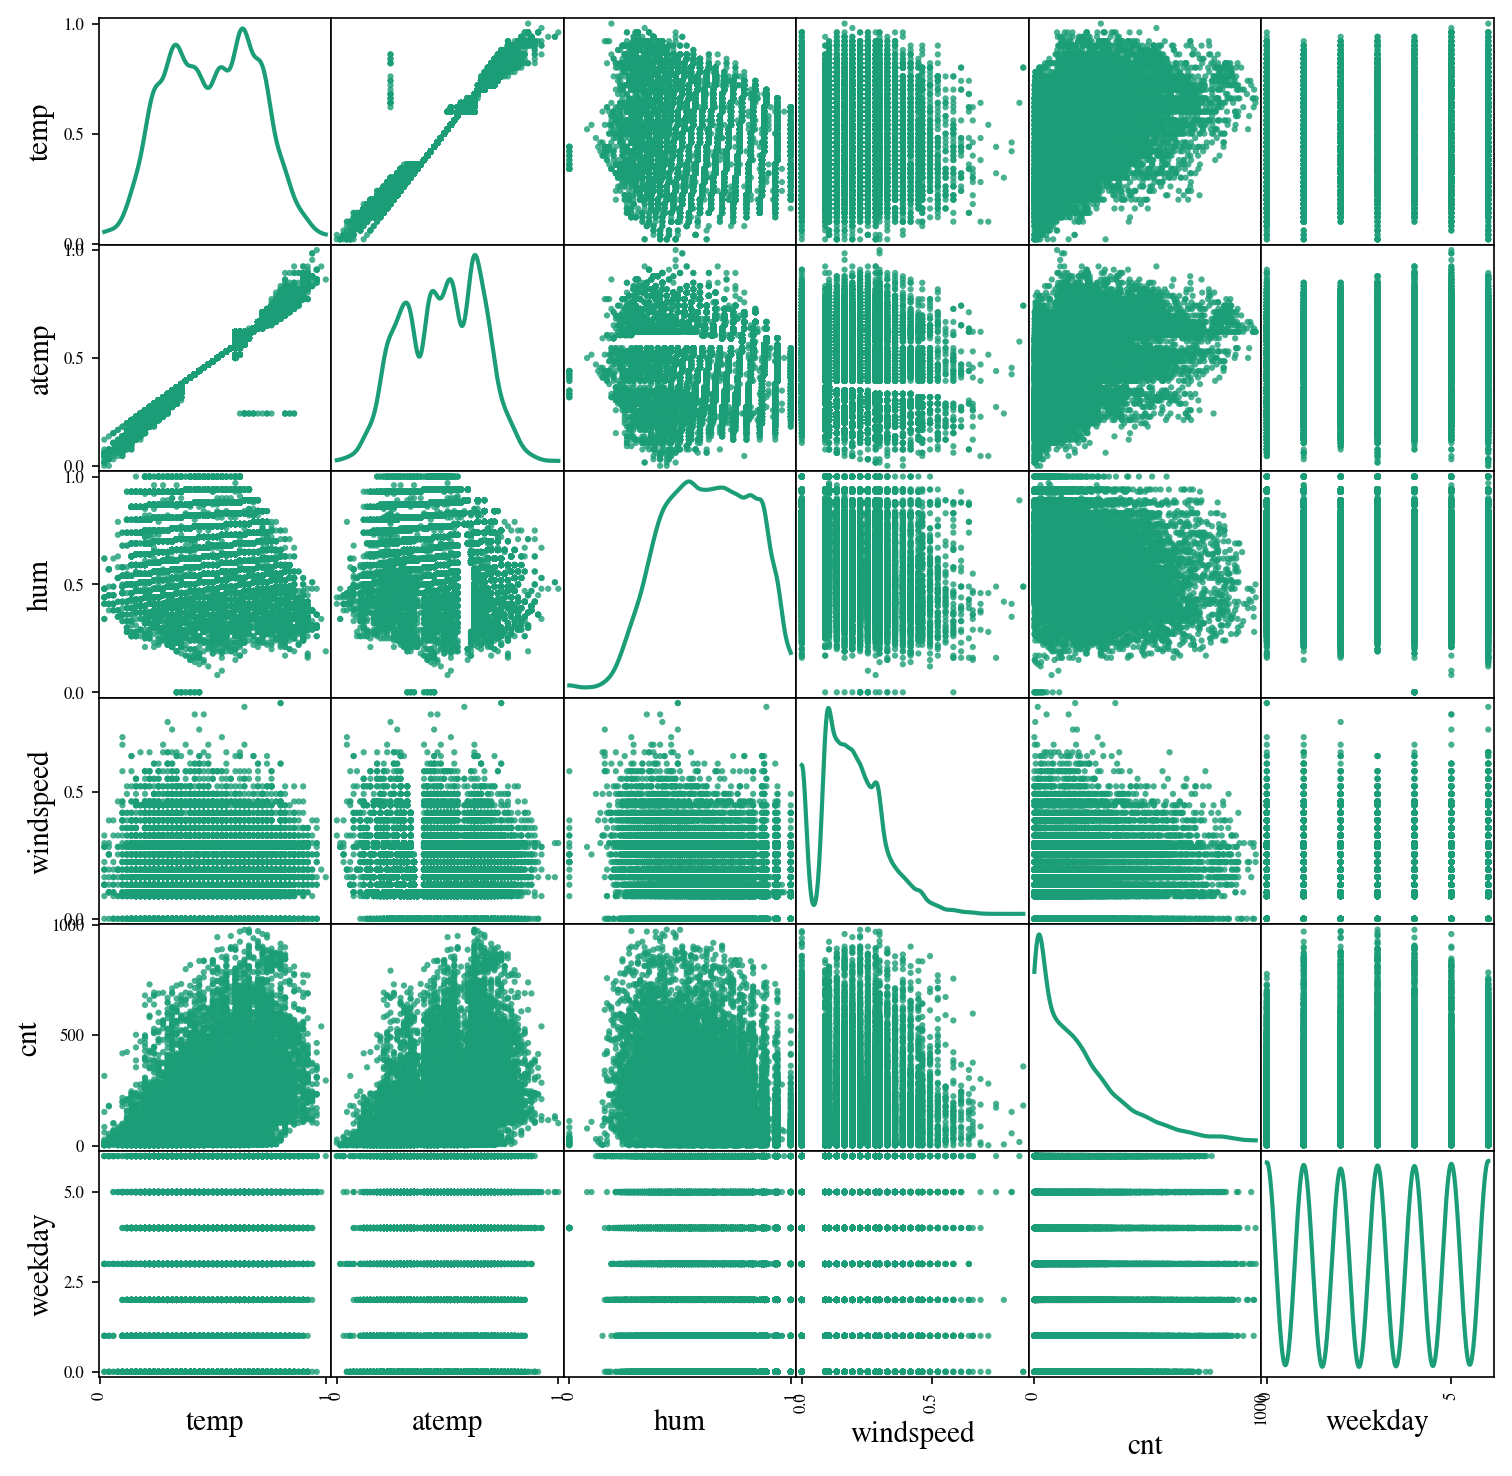

In [11]:
#Instruction5: use a SPLOM to visualize some columns of this dataset. In Panda's the SPLOM is a one-liner.

smaller_frame=df[['temp', 'atemp', 'hum', 'windspeed', 'cnt', 'weekday']]
from pandas.plotting import scatter_matrix
axeslist=scatter_matrix(smaller_frame, alpha=0.8, figsize=(12, 12), diagonal="kde")
for ax in axeslist.flatten():
    ax.grid(False)

pylab.savefig('Scatter Matrix', dpi = 80, figsize = (20,6))
plt.show()    

In [12]:
#Instruction6:Is there any strong correlation between any of the features.  Run a correlation analysis on the three features.

smaller_frame.corr()

temp     atemp       hum  windspeed       cnt   weekday
temp       1.000000  0.987672 -0.069881  -0.023125  0.404772 -0.001795
atemp      0.987672  1.000000 -0.051918  -0.062336  0.400929 -0.008821
hum       -0.069881 -0.051918  1.000000  -0.290105 -0.322911 -0.037158
windspeed -0.023125 -0.062336 -0.290105   1.000000  0.093234  0.011502
cnt        0.404772  0.400929 -0.322911   0.093234  1.000000  0.026900
weekday   -0.001795 -0.008821 -0.037158   0.011502  0.026900  1.000000

In [14]:
#Instruction7: Carry out the regression, first standardizing our variables. This is strictly not necessary, but we are doing it as we wish to play around with PCA. 
#Since scikit-learn wants a n_sample rows times n_features matrix, we need to reshape the x variable. We store both an _vec variable, which is easier to plot with, 
#as well as the reshaped variable. 

from sklearn.linear_model import LinearRegression
X_HD=smaller_frame[['temp', 'cnt']].values
X_HDn=(X_HD - X_HD.mean(axis=0))/X_HD.std(axis=0)
temp_std_vec=X_HDn[:,0]
temp_std=temp_std_vec.reshape(-1,1)
cnt_std_vec=X_HDn[:,1]
cnt_std=cnt_std_vec.reshape(-1,1)

In [15]:
#Instruction8: Split the data into a training set and a testing set. By default, 25% of the data is reserved for testing. 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(temp_std, cnt_std_vec)

In [16]:
#Instrusction9: Use the training set for the fit, and find what our predictions ought to be on both the training and test set.

cnt_temp = LinearRegression()
cnt_temp.fit(X_train, y_train)
predicted_train = cnt_temp.predict(X_train)
predicted_test = cnt_temp.predict(X_test)
trains=X_train.reshape(1,-1).flatten()
tests=X_test.reshape(1,-1).flatten()
print (cnt_temp.coef_, cnt_temp.intercept_)

[ 0.40671709] 0.00581793185735


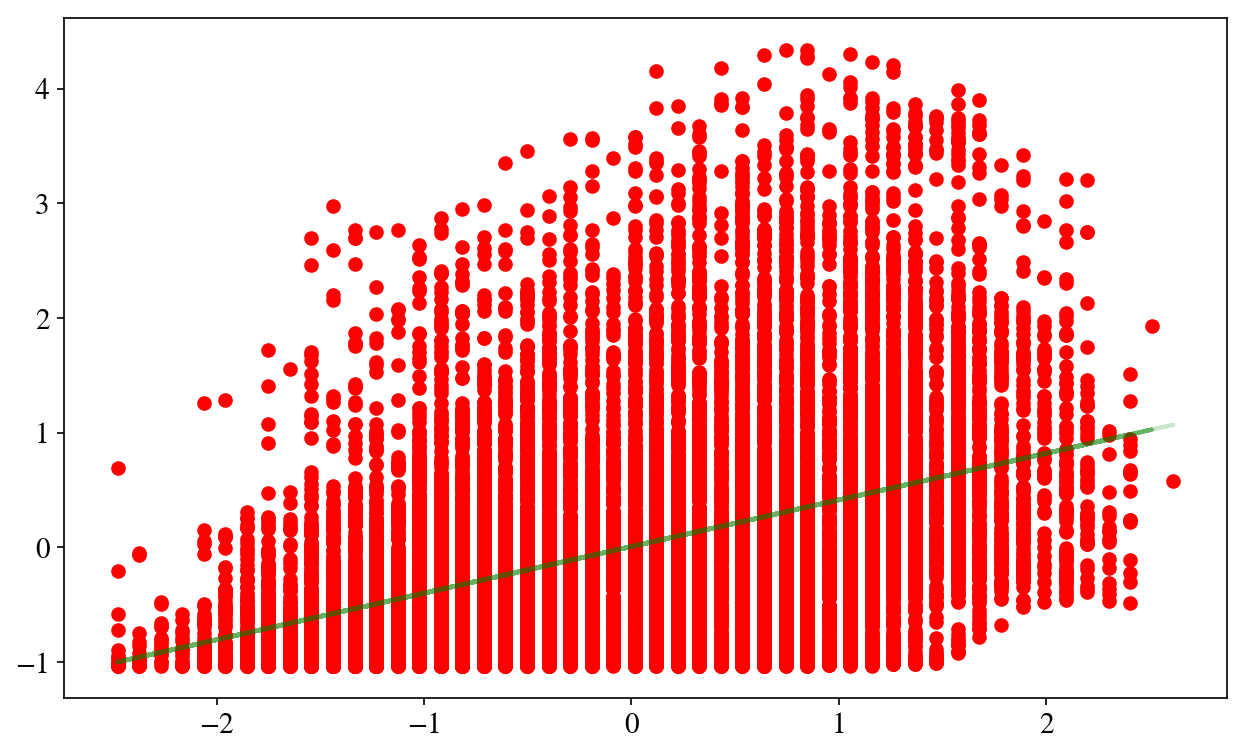

In [18]:
#Instruction10: Plot the scatter against the fit for both training and test data.

plt.scatter(temp_std_vec, cnt_std_vec,c='r')
plt.plot(trains, predicted_train, c='g', alpha=0.5)
plt.plot(tests, predicted_test, c='g', alpha=0.2)

plt.show()

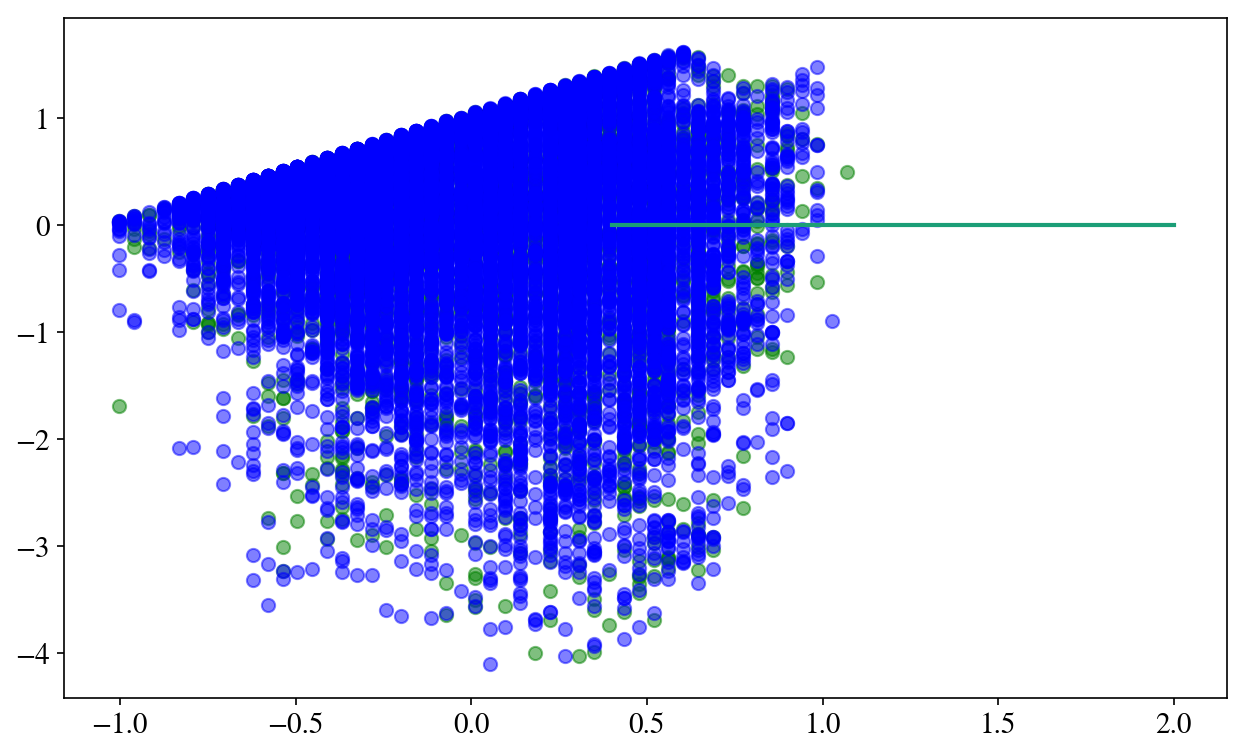

In [24]:
plt.scatter(predicted_test, predicted_test- y_test, c='g', s=40, alpha=0.5)
plt.scatter(predicted_train, predicted_train- y_train, c='b', s=40, alpha=0.5)
plt.plot([0.4,2],[0,0])

plt.show()

In [20]:
#Instruction12: Take the standarddized data and do a 2-D PCA on it. 
#Here we do not seek to accomplish a dimensional reduction, but to understand the variance structure of the data.

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = pca.fit_transform(X_HDn)
print (pca.explained_variance_ratio_)

[ 0.70238614  0.29761386]


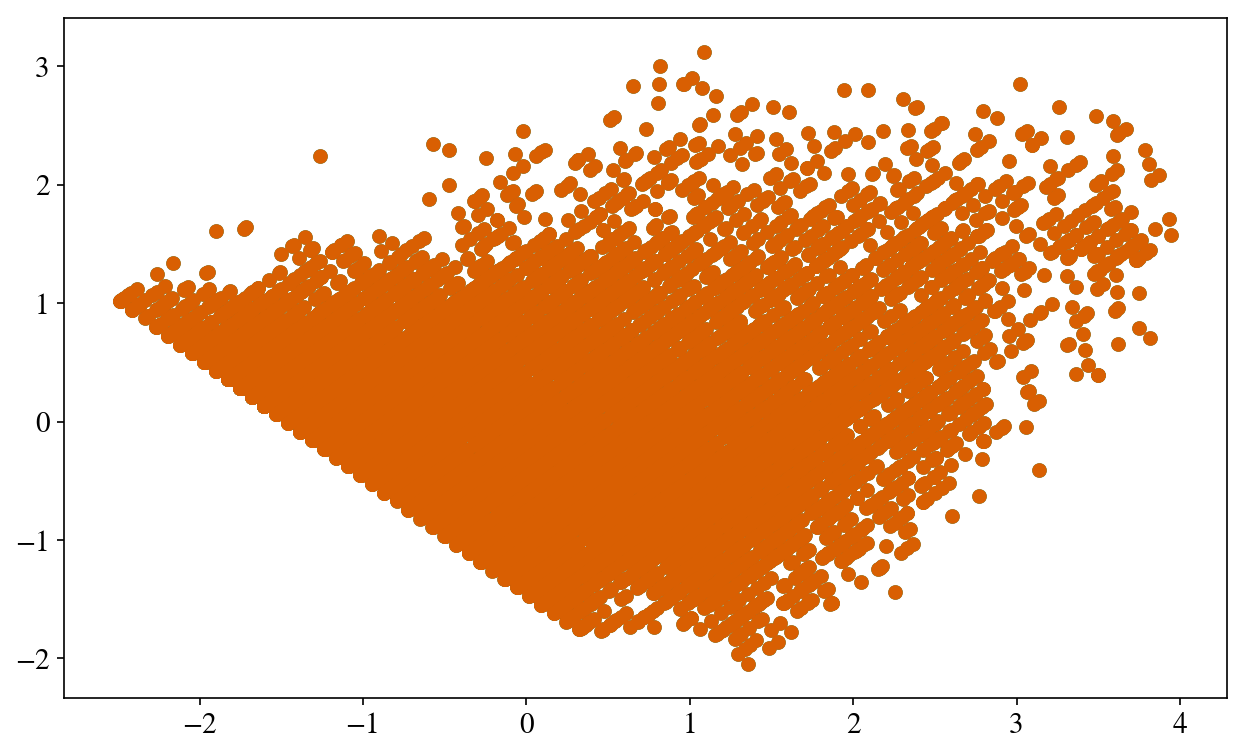

In [22]:
plt.scatter(X[:, 0], X[:, 1])

plt.show()

In [23]:
#Instruction13: Reconstruct the original data from only the first component, setting the others to 0.

pca1 = PCA(n_components=1) # only keep one dimension!
X_E = pca1.fit_transform(X_HDn)
X_reconstructed = pca1.inverse_transform(X_E)

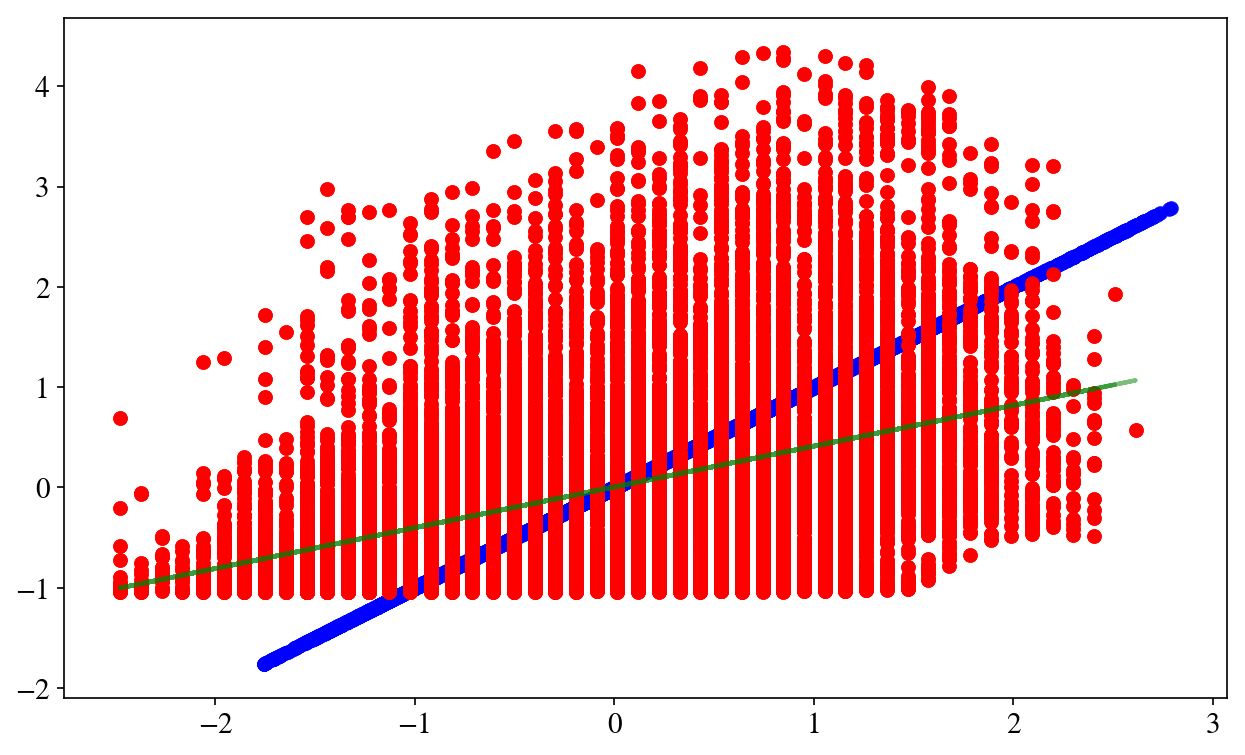

In [26]:
plt.scatter(X_reconstructed[:,0], X_reconstructed[:,1],c='b', s=35, alpha=0.7)
plt.scatter(temp_std_vec, cnt_std_vec,c='r')
plt.plot(trains, predicted_train, c='g', alpha=0.3)
plt.plot(tests, predicted_test, c='g', alpha=0.3)

plt.show()

In [27]:
#Part2: Logistic Regression Instuctions

#Instruction1: Load the array
data=np.array([[ 66.,   0.],
       [ 70.,   1.],
       [ 69.,   0.],
       [ 68.,   0.],
       [ 67.,   0.],
       [ 72.,   0.],
       [ 73.,   0.],
       [ 70.,   0.],
       [ 57.,   1.],
       [ 63.,   1.],
       [ 70.,   1.],
       [ 78.,   0.],
       [ 67.,   0.],
       [ 53.,   1.],
       [ 67.,   0.],
       [ 75.,   0.],
       [ 70.,   0.],
       [ 81.,   0.],
       [ 76.,   0.],
       [ 79.,   0.],
       [ 75.,   1.],
       [ 76.,   0.],
       [ 58.,   1.]])

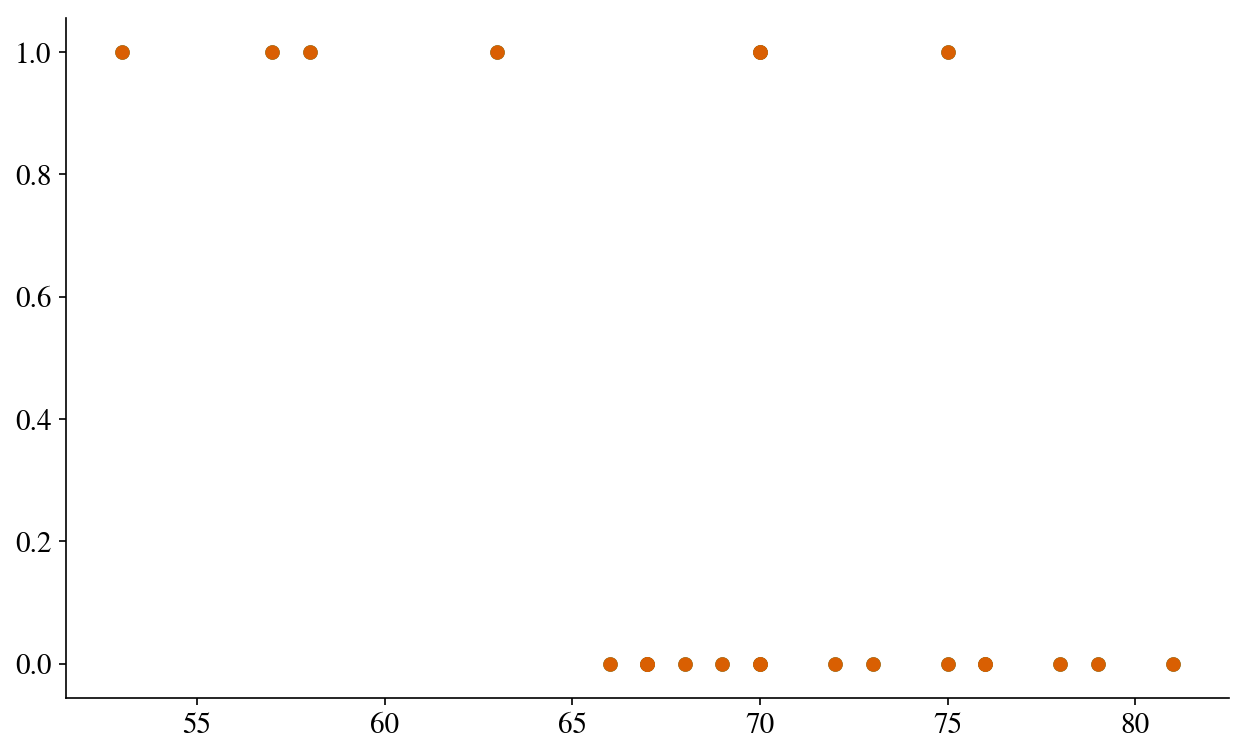

In [29]:
#Instruction2: Plot the array.

temps, pfail = data[:,0], data[:,1]
plt.scatter(temps, pfail)
axes=plt.gca()
axes.grid(False)
remove_border(axes)

plt.show()

In [30]:
#Instruction3: Run Logistic Regression with sklearn.linear_model and set c to 1000.

from sklearn.linear_model import LogisticRegression
reg=1000.
clf4 = LogisticRegression(C=reg)
clf4.fit(temps.reshape(-1,1), pfail)

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [31]:
#Instruction4: Make predictions, get the associated probabilities, and plot them.

tempsnew=np.linspace(20., 90., 15)
probs = clf4.predict_proba(tempsnew.reshape(-1,1))[:, 1]
predicts = clf4.predict(tempsnew.reshape(-1,1))

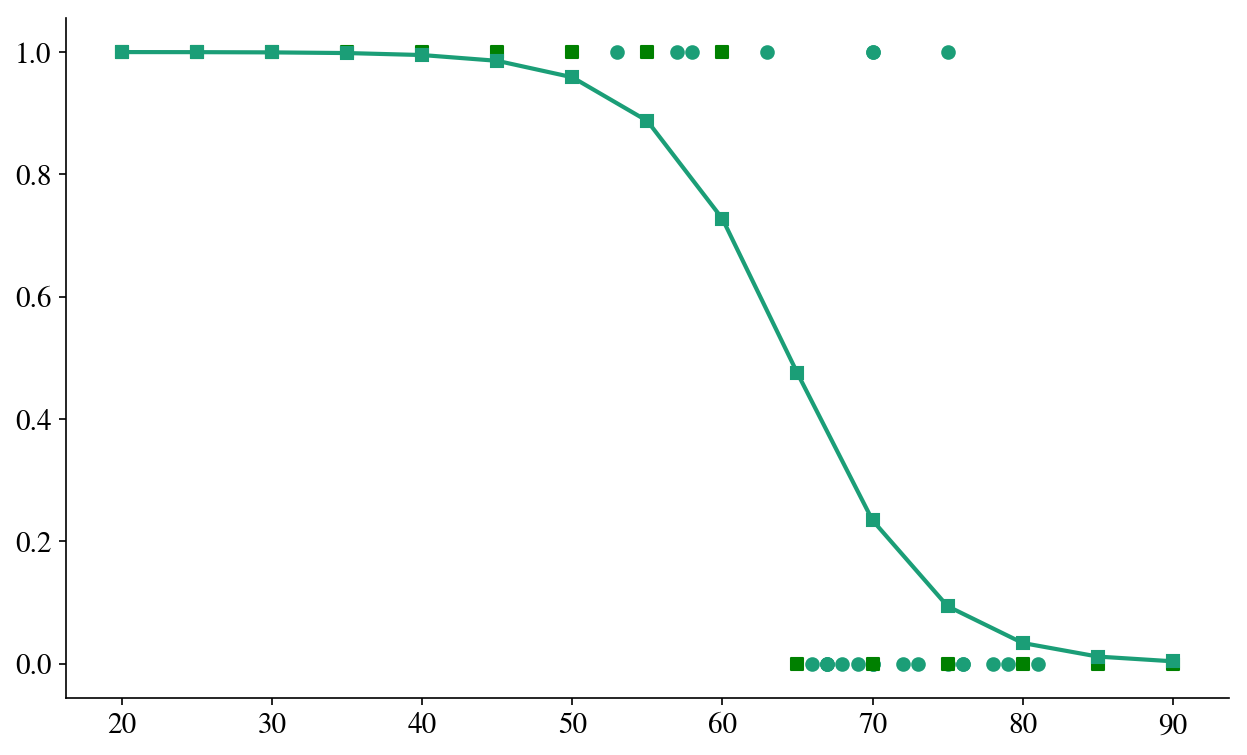

In [32]:
plt.scatter(temps, pfail)
axes=plt.gca()
axes.grid(False)
remove_border(axes)
plt.plot(tempsnew, probs, marker='s')
plt.scatter(tempsnew, predicts, marker='s', color="green")

plt.show()

In [33]:
#Instruction5: use pandas crosstab to write a table of prediction vs failure on the "training" set.

pd.crosstab(pfail, clf4.predict(temps.reshape(-1,1)), rownames=["Actual"], colnames=["Predicted"])

Predicted  0.0  1.0
Actual             
0.0         16    0
1.0          3    4

In [ ]:
#Part3: Bias and Variance and Cross Validation

In [34]:
# Instruction1: Load the settings needed for part3

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import brewer2mpl
from matplotlib import rcParams

#colorbrewer2 Dark2 qualitative color table
dark2_cmap = brewer2mpl.get_map('Dark2', 'Qualitative', 7)
dark2_colors = dark2_cmap.mpl_colors

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
import warnings
warnings.filterwarnings('ignore', message='Polyfit*')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [35]:
import random
import copy
def scatter_by(df, scatterx, scattery, by=None, figure=None, axes=None, colorscale=dark2_cmap, labeler={}, mfunc=None, setupfunc=None, mms=8):
    cs=copy.deepcopy(colorscale.mpl_colors)
    if not figure:
        figure=plt.figure(figsize=(8,8))
    if not axes:
        axes=figure.gca()
    x=df[scatterx]
    y=df[scattery]
    if not by:
        col=random.choice(cs)
        axes.scatter(x, y, cmap=colorscale, c=col)
        if setupfunc:
            axeslist=setupfunc(axes, figure)
        else:
            axeslist=[axes]
        if mfunc:
            mfunc(axeslist,x,y,color=col, mms=mms)
    else:
        cs=list(np.linspace(0,1,len(df.groupby(by))))
        xlimsd={}
        ylimsd={}
        xs={}
        ys={}
        cold={}
        for k,g in df.groupby(by):
            col=cs.pop()
            x=g[scatterx]
            y=g[scattery]
            xs[k]=x
            ys[k]=y
            c=colorscale.mpl_colormap(col)
            cold[k]=c
            axes.scatter(x, y, c=c, label=labeler.get(k,k), s=40, alpha=0.3);
            xlimsd[k]=axes.get_xlim()
            ylimsd[k]=axes.get_ylim()
        xlims=[min([xlimsd[k][0] for k in xlimsd.keys()]), max([xlimsd[k][1] for k in xlimsd.keys()])]
        ylims=[min([ylimsd[k][0] for k in ylimsd.keys()]), max([ylimsd[k][1] for k in ylimsd.keys()])]
        axes.set_xlim(xlims)
        axes.set_ylim(ylims)
        if setupfunc:
            axeslist=setupfunc(axes, figure)
        else:
            axeslist=[axes]
        if mfunc:
            for k in xs.keys():
                mfunc(axeslist,xs[k],ys[k],color=cold[k], mms=mms);
    axes.set_xlabel(scatterx);
    axes.set_ylabel(scattery);
    
    return axes

def make_rug(axeslist, x, y, color='b', mms=8):
    axes=axeslist[0]
    zerosx1=np.zeros(len(x))
    zerosx2=np.zeros(len(x))
    xlims=axes.get_xlim()
    ylims=axes.get_ylim()
    zerosx1.fill(ylims[1])
    zerosx2.fill(xlims[1])
    axes.plot(x, zerosx1, marker='|', color=color, ms=mms)
    axes.plot(zerosx2, y, marker='_', color=color, ms=mms)
    axes.set_xlim(xlims)
    axes.set_ylim(ylims)
    return axes

In [36]:
#Instruction2: Load your dataset

import pandas as pd
df=pd.read_csv("hour.csv")
print(len(df.columns))
print(len(df.index))
df.head(7)

20
17379


instant    dteday  season  yr  mnth  hr  holiday  weekday  workingday  weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  Start  End  Duration
0        1  1/1/2011       1   0     1   0        0        6           0           1  0.24  0.2879  0.81     0.0000       3          13   16    NaN  NaN       NaN
1        2  1/1/2011       1   0     1   1        0        6           0           1  0.22  0.2727  0.80     0.0000       8          32   40    NaN  NaN       NaN
2        3  1/1/2011       1   0     1   2        0        6           0           1  0.22  0.2727  0.80     0.0000       5          27   32    NaN  NaN       NaN
3        4  1/1/2011       1   0     1   3        0        6           0           1  0.24  0.2879  0.75     0.0000       3          10   13    NaN  NaN       NaN
4        5  1/1/2011       1   0     1   4        0        6           0           1  0.24  0.2879  0.75     0.0000       0           1    1    NaN  NaN       NaN
5        6  1/1/2011       1   0     1   5        0        6           0           2  0.24  0.2576  0.75     0.0896       0           1    1    NaN  NaN       NaN
6        7  1/1/2011       1   0     1   6        0        6           0           1  0.22  0.2727  0.80     0.0000       2           0    2    NaN  NaN       NaN

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


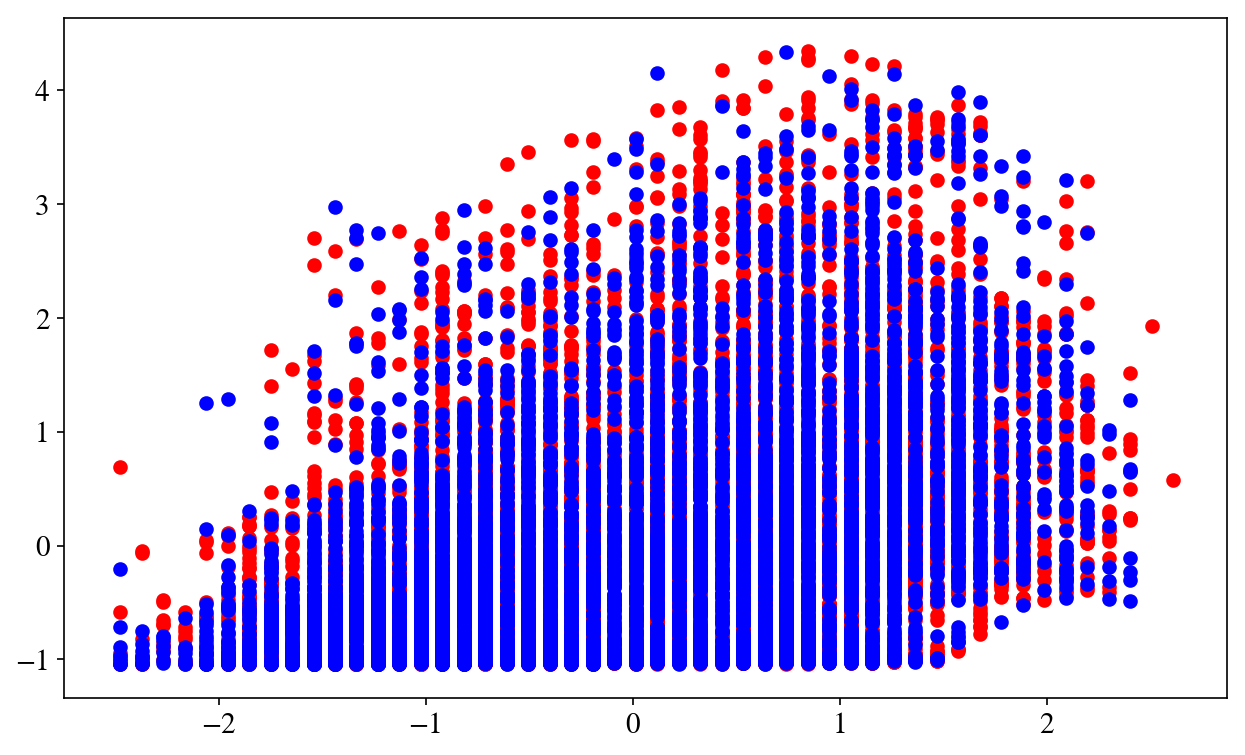

In [37]:
#Instruction3: Split the data set into equal parts test and training using the std vectors from Part1
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(radius_std, texture_std_vec)

X_HD=smaller_frame[['temp', 'cnt']].values
X_HDn=(X_HD - X_HD.mean(axis=0))/X_HD.std(axis=0)
temp_std_vec=X_HDn[:,0]
temp_std=temp_std_vec.reshape(-1,1)
cnt_std_vec=X_HDn[:,1]
cnt_std=cnt_std_vec.reshape(-1,1)

from sklearn.cross_validation import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(temp_std, cnt_std_vec, train_size=0.6)
plt.scatter(xtrain, ytrain, color='red')
plt.scatter(xtest, ytest, color='blue')

plt.show()


In [38]:
#Instruction4: Create a column called "class" and randomly add a "1", "2", or "3" for every row.

df['randNumCol'] = np.random.randint(1, 4, df.shape[0])
print(df.columns)

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt', 'Start', 'End', 'Duration', 'randNumCol'], dtype='object')


In [40]:
print(df['randNumCol'])

0        3
1        2
2        1
3        3
4        2
5        3
6        1
7        3
8        3
9        2
10       1
11       3
12       3
13       3
14       3
15       3
16       2
17       1
18       1
19       2
20       3
21       3
22       1
23       1
24       1
25       1
26       2
27       1
28       3
29       3
        ..
17349    2
17350    1
17351    1
17352    2
17353    1
17354    3
17355    2
17356    3
17357    2
17358    1
17359    3
17360    3
17361    2
17362    1
17363    1
17364    1
17365    3
17366    2
17367    3
17368    2
17369    3
17370    1
17371    3
17372    1
17373    2
17374    2
17375    3
17376    2
17377    1
17378    3
Name: randNumCol, Length: 17379, dtype: int32


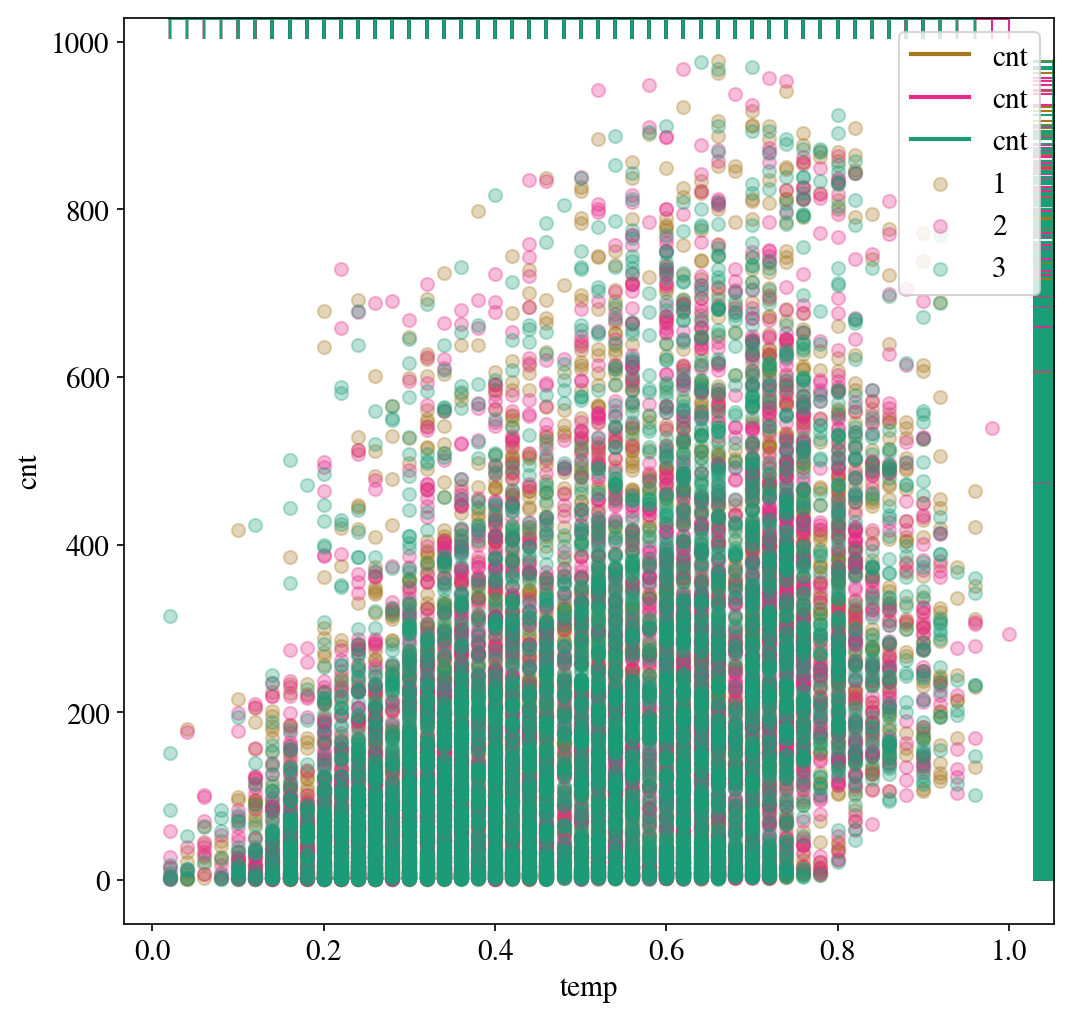

In [41]:
#Instruction5: Choose three different features in your dataset and cluster them by the randomNumCol

akeys=[1,2,3]
avals=['1','2','3']
amap={e[0]:e[1] for e in zip(akeys,avals)}
ax=scatter_by(df, 'temp', 'cnt', by='randNumCol', labeler=amap, mfunc=make_rug, mms=20)
ax.grid(False)
ax.legend(loc='upper right')

plt.show()

In [42]:
#Instructin6: Add plotting settings
from matplotlib.colors import ListedColormap
#cm_bright = ListedColormap(['#FF0000', '#000000','#0000FF'])
#cm = plt.cm.RdBu
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def points_plot(X, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold):
    h = .02
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                         np.linspace(y_min, y_max, 50))

    plt.figure()
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=0.2)
    plt.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cdiscrete, s=50, alpha=0.2,edgecolor="k")
    # and testing points
    yact=clf.predict(Xte)
    print ("SCORE"), clf.score(Xte, yte)
    plt.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cdiscrete, alpha=0.5, marker="s", s=35)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    return ax

In [43]:
#Instruction7: Develop a kNN with 20 neighbors
from sklearn.neighbors import KNeighborsClassifier
subdf=df[['temp','cnt']]
subdfstd=(subdf - subdf.mean())/subdf.std()
X=subdfstd.values
y=df['randNumCol'].values
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.6)
Xtr=np.concatenate((Xtrain, Xtest))

SCORE


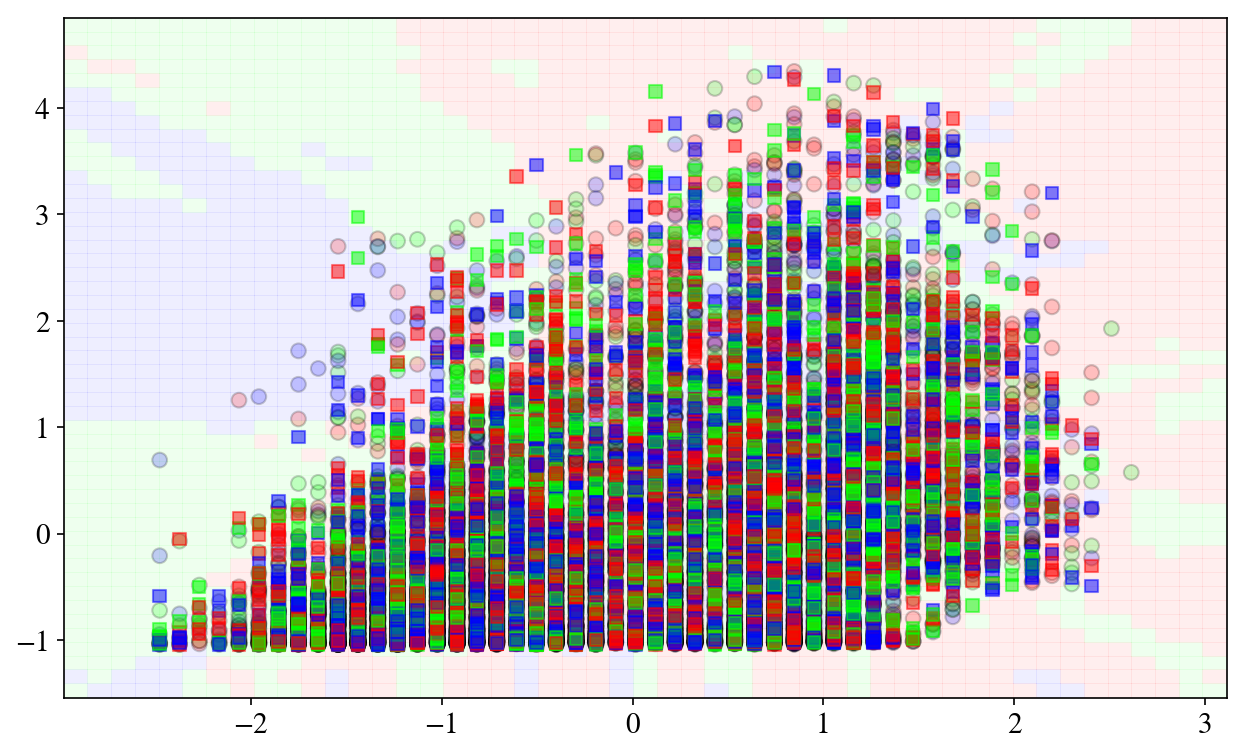

In [44]:
#Instruction8: Plot the kNN model with 20 neighbors

clf = KNeighborsClassifier(20).fit(Xtrain, ytrain)
points_plot(Xtr, Xtrain, Xtest, ytrain, ytest, clf)

SCORE


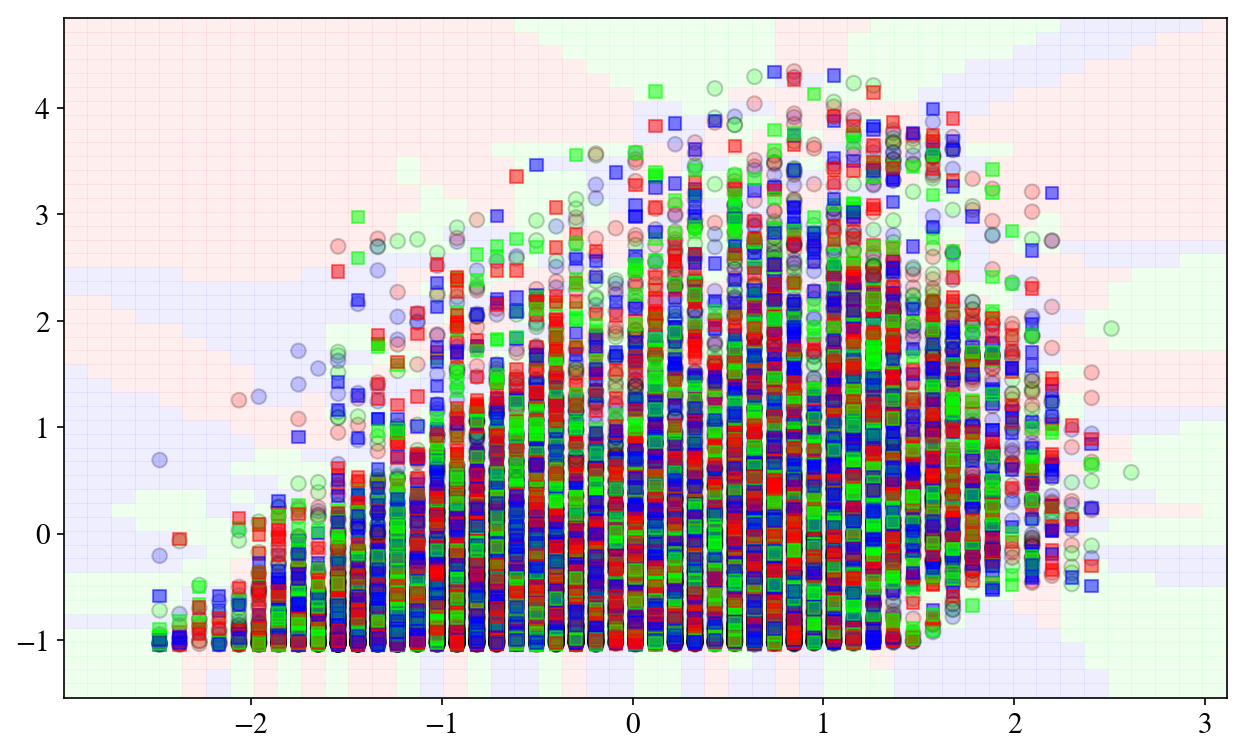

In [45]:
##Instruction9: Plot the kNN model with 1 neighbors

clf = KNeighborsClassifier(1).fit(Xtrain, ytrain)
points_plot(Xtr, Xtrain, Xtest, ytrain, ytest, clf)

SCORE


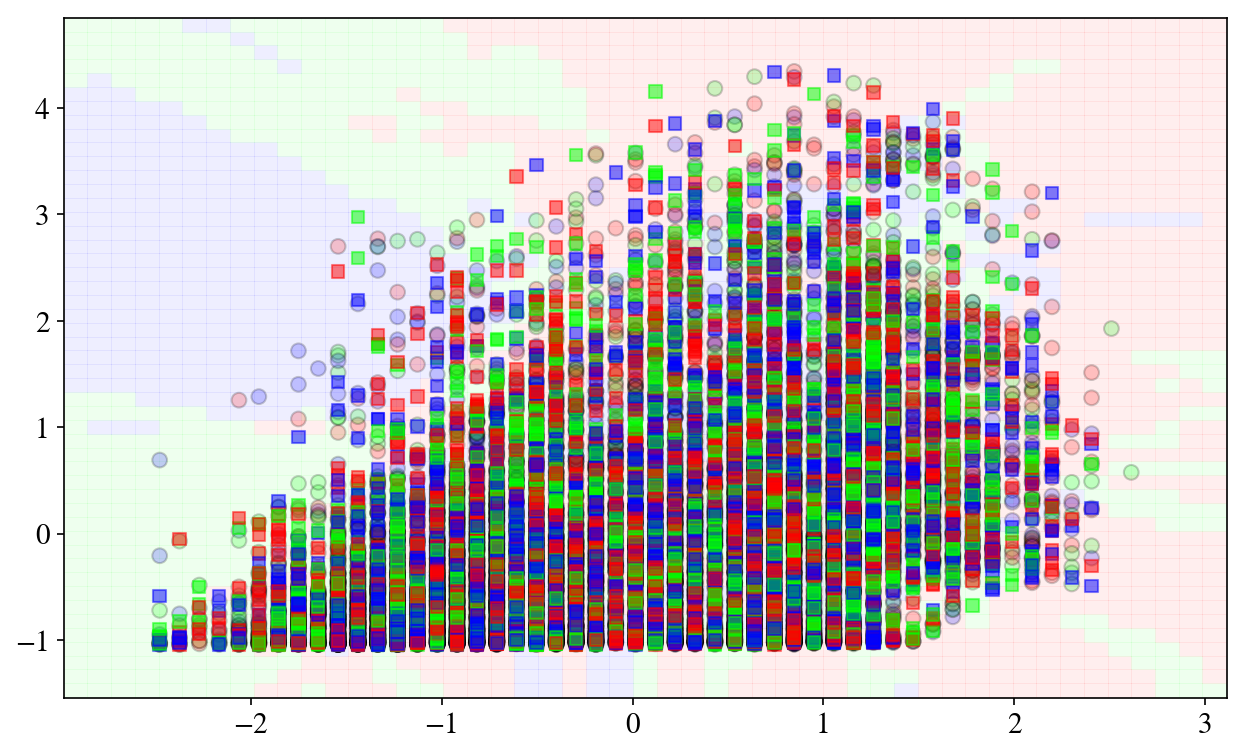

In [46]:
##Instruction10: Plot the kNN model with 35 neighbors
clf = KNeighborsClassifier(35).fit(Xtrain, ytrain)
points_plot(Xtr, Xtrain, Xtest, ytrain, ytest, clf)

(10427,) (3476,) (3476,)
0.34752589183


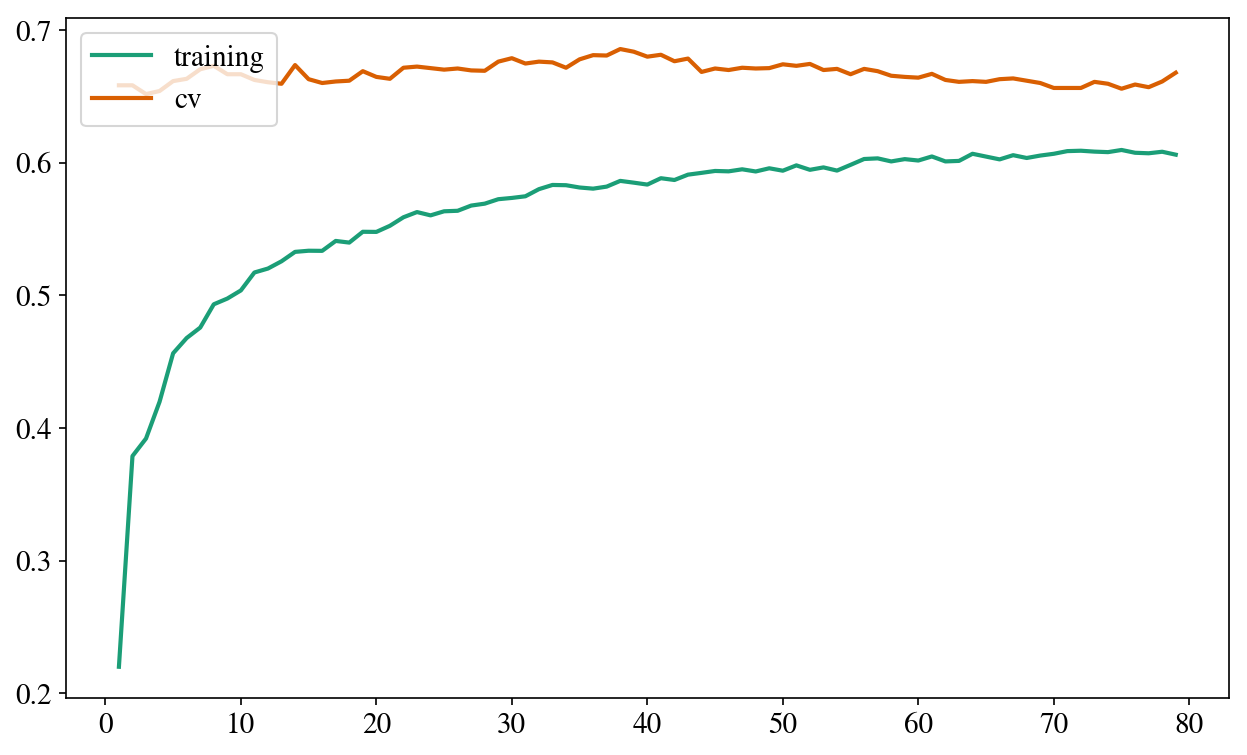

In [47]:
#Instruction#11: Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8)
Xtr=np.concatenate((Xtrain, Xtest))
Xcv,Xte,ycv,yte=train_test_split(Xtest, ytest, train_size=0.5)
print (ytrain.shape, ycv.shape, yte.shape)
trscores=[]
cvscores=[]
ns=np.arange(1,80,1)
ones=np.ones(len(ns))
for n in ns:
    clf = KNeighborsClassifier(n).fit(Xtrain, ytrain)
    trscores.append(clf.score(Xtrain, ytrain))
    cvscores.append(clf.score(Xcv, ycv))
plt.plot(ns, ones-trscores, label="training")
plt.plot(ns, ones-cvscores, label="cv")
plt.legend(loc='upper left');
print (clf.score(Xte, yte))

In [48]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8)
Xtr=np.concatenate((Xtrain, Xtest))

In [49]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
parameters = {"n_neighbors": np.arange(1,80,1)}
clf = KNeighborsClassifier()
gs = GridSearchCV(clf, param_grid=parameters, cv=10)
gs.fit(Xtrain, ytrain)
#print gs.grid_scores_
print (gs.best_params_, gs.best_score_)
y_true, y_pred = ytest, gs.predict(Xtest)
print(classification_report(y_true, y_pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


{'n_neighbors': 13} 0.3429475652736819
             precision    recall  f1-score   support

          1       0.33      0.39      0.36      1179
          2       0.32      0.30      0.31      1186
          3       0.33      0.29      0.31      1111

avg / total       0.33      0.33      0.33      3476



SCORE


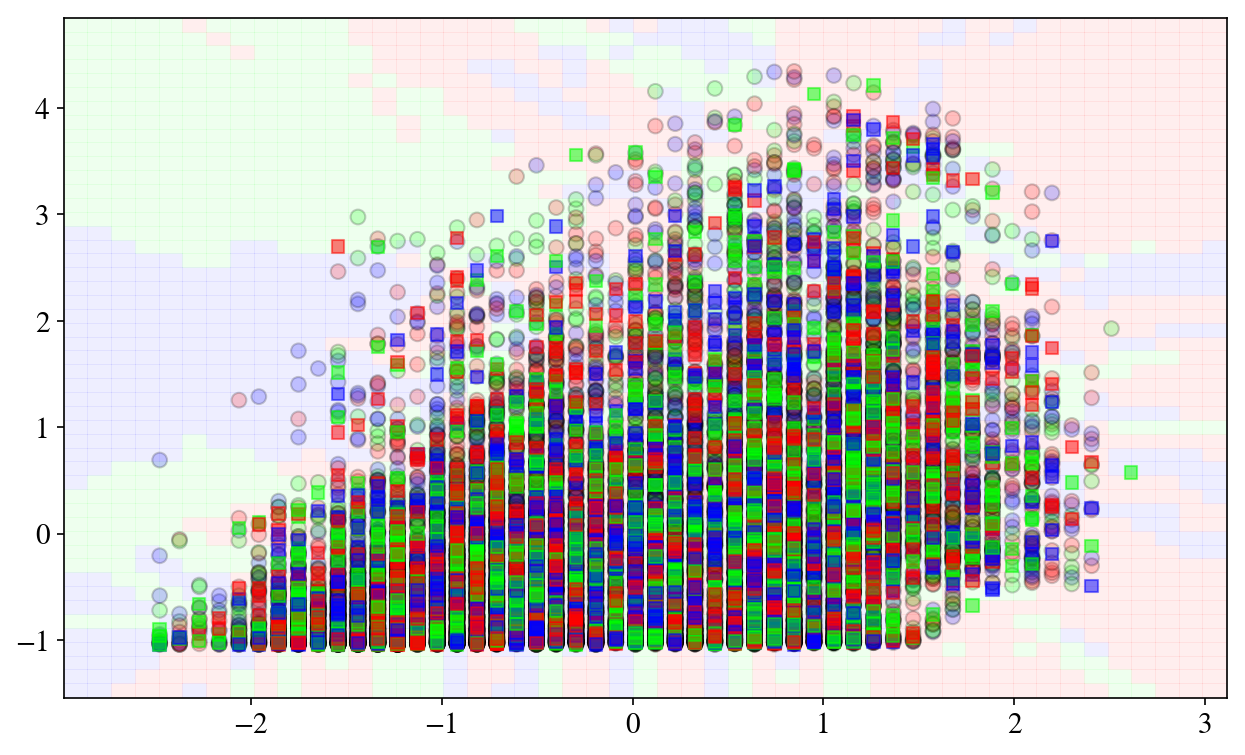

In [50]:
points_plot(Xtr, Xtrain, Xtest, ytrain, ytest, gs)

In [8]:
# Checking the specific date.
print('temp on a specific date:')
print(df[df['dteday']=='1/1/2011']['temp'])

temp on a specific date:
0     0.24
1     0.22
2     0.22
3     0.24
4     0.24
5     0.24
6     0.22
7     0.20
8     0.24
9     0.32
10    0.38
11    0.36
12    0.42
13    0.46
14    0.46
15    0.44
16    0.42
17    0.44
18    0.42
19    0.42
20    0.40
21    0.40
22    0.40
23    0.46
Name: temp, dtype: float64


In [9]:
np.corrcoef(df[df['dteday']=='1/1/2011']['temp'],df[df['dteday']=='1/1/2011']['cnt'])

array([[ 1.        ,  0.75059529],
       [ 0.75059529,  1.        ]])

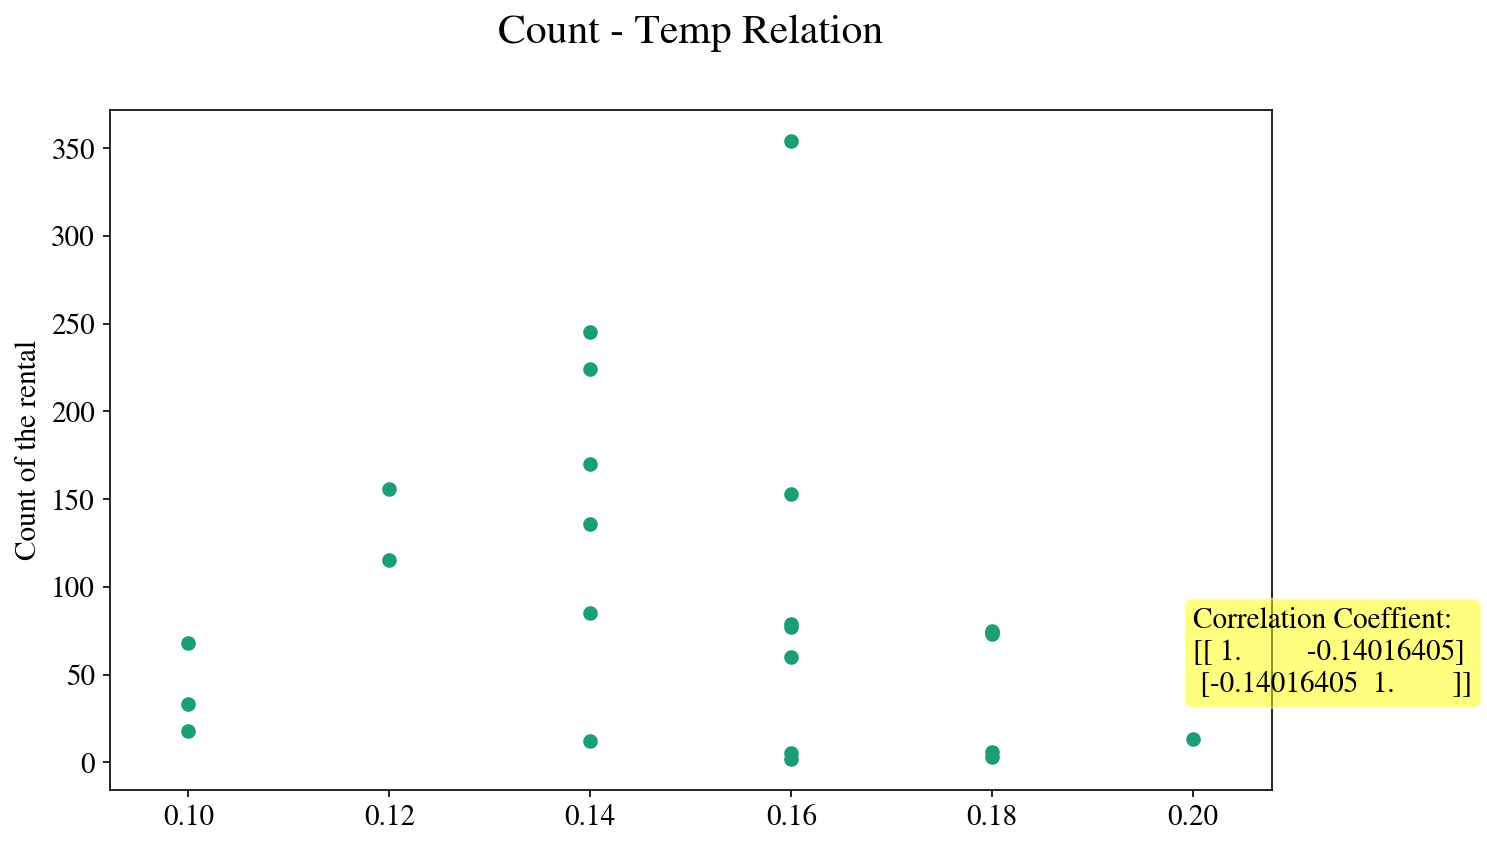

In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)

ax1.scatter(df[df['dteday']=='1/3/2012']['temp'],df[df['dteday']=='1/3/2012']['cnt'])
ax1.set_ylabel("Count of the rental")
ax1.set_xlabel("")
ax1.set_title("Count - Temp Relation", y=1.08, x=0.5, fontsize = 20)
ax1.annotate('Correlation Coeffient: \n{}'.format(np.corrcoef(df[df['dteday']=='1/3/2012']['temp'],df[df['dteday']=='1/3/2012']['cnt'])),
                     xy=(0.2,40), bbox=dict(boxstyle='round', fc='yellow', alpha=0.5))

plt.show()

In [12]:
# Checking temperature - counts relation with constant weekday:
weekday = set(df['weekday'])

for day in weekday:
    print("Correlation Coefficient for weekday {} is \n{}". format(day, np.corrcoef(df[df['weekday']==day]['temp'],df[df['weekday']==day]['cnt'])))
    


Correlation Coefficient for weekday 0 is 
[[ 1.          0.50644602]
 [ 0.50644602  1.        ]]
Correlation Coefficient for weekday 1 is 
[[ 1.          0.38250787]
 [ 0.38250787  1.        ]]
Correlation Coefficient for weekday 2 is 
[[ 1.          0.34687779]
 [ 0.34687779  1.        ]]
Correlation Coefficient for weekday 3 is 
[[ 1.          0.36282241]
 [ 0.36282241  1.        ]]
Correlation Coefficient for weekday 4 is 
[[ 1.          0.34538431]
 [ 0.34538431  1.        ]]
Correlation Coefficient for weekday 5 is 
[[ 1.          0.38507846]
 [ 0.38507846  1.        ]]
Correlation Coefficient for weekday 6 is 
[[ 1.          0.51183697]
 [ 0.51183697  1.        ]]


In [44]:
# Checking temperature - counts relation with constant weekday and without holiday factors:
weekday = set(df['weekday'])

for day in weekday:
    if df['holiday'] == 0:
        print("Correlation Coefficient for weekday {} is \n{}". format(day, np.corrcoef(df[df['weekday']==day]['temp'],df[df['weekday']==day]['cnt'])))
    


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

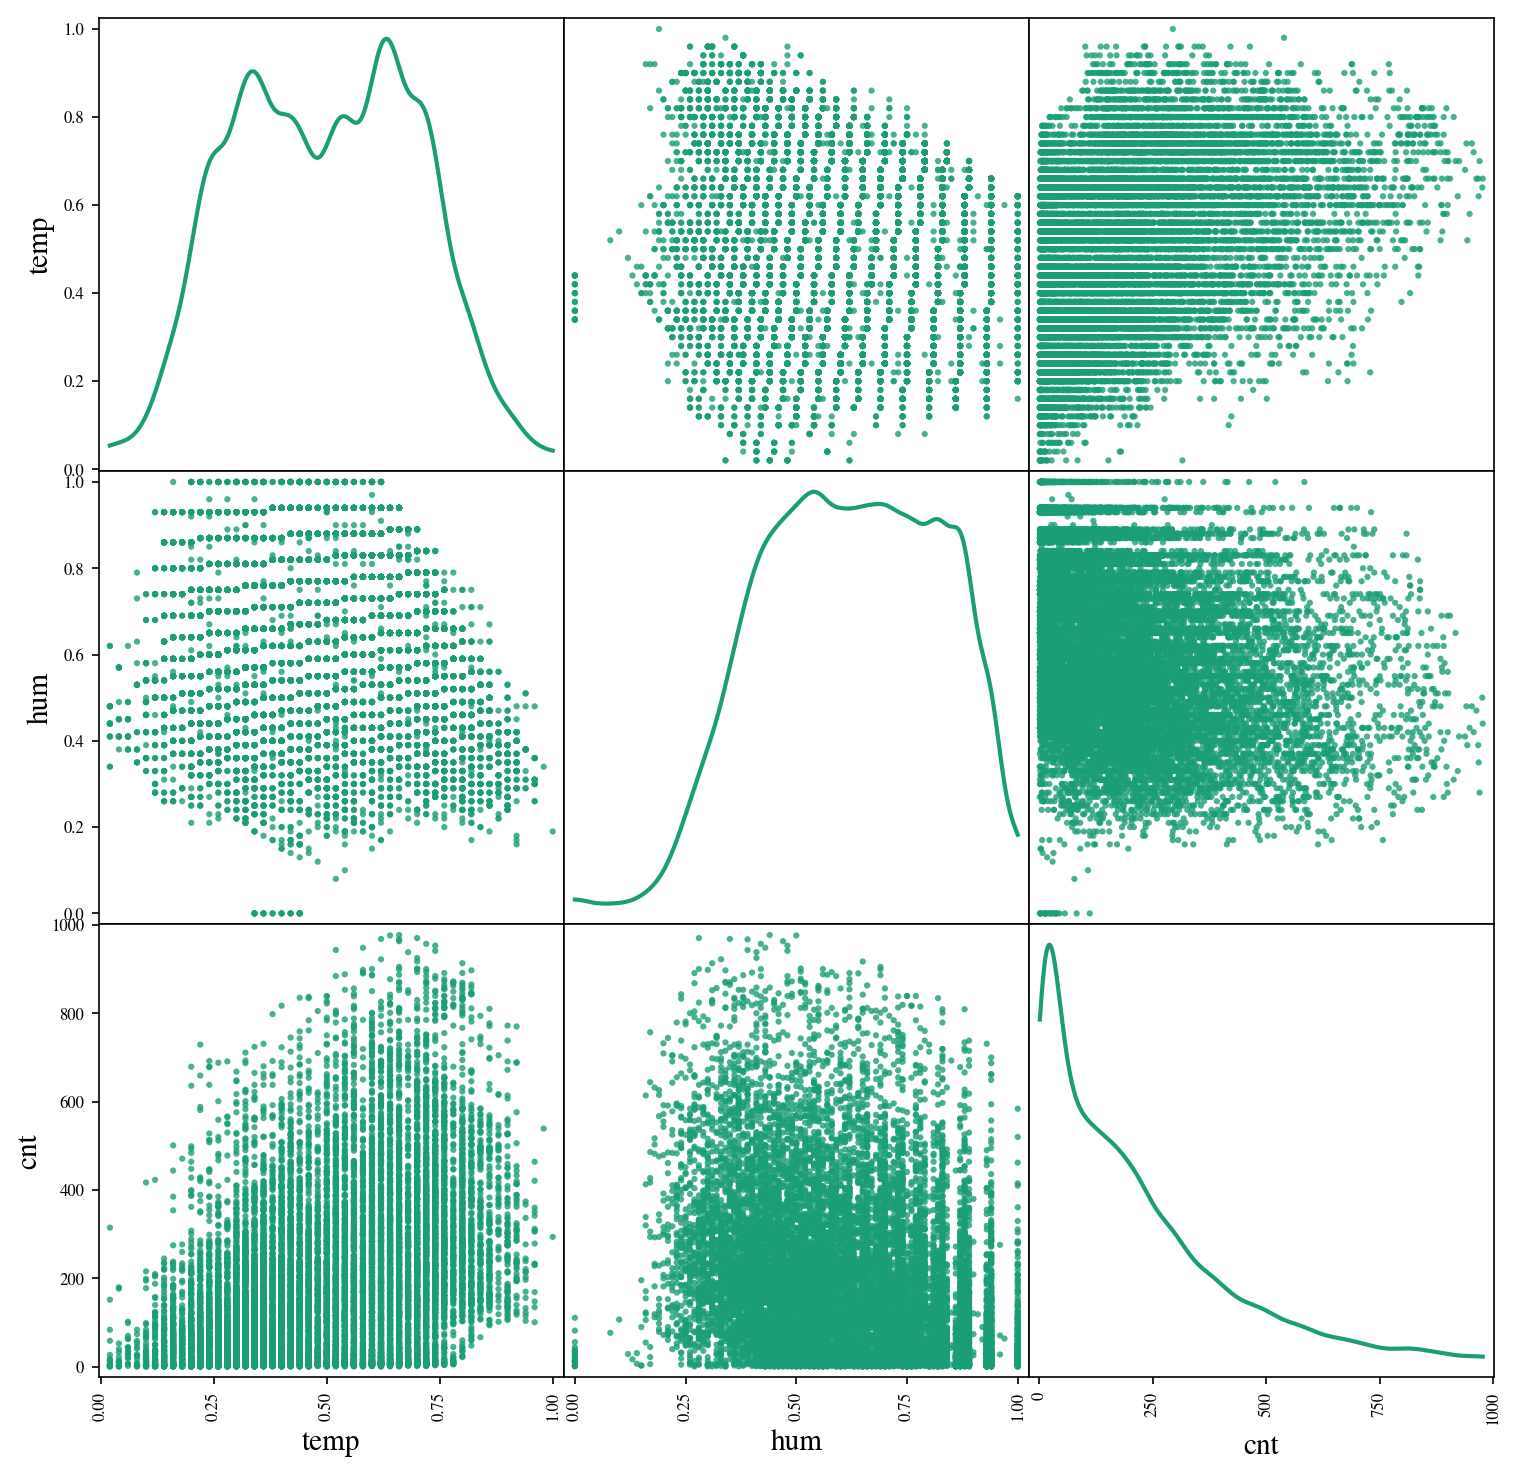

In [13]:
smaller_frame=df[['temp', 'hum', 'cnt']]
from pandas.plotting import scatter_matrix
axeslist=scatter_matrix(smaller_frame, alpha=0.8, figsize=(12, 12), diagonal="kde")
for ax in axeslist.flatten():
    ax.grid(False)
    
plt.show()

In [14]:
print(smaller_frame.corr())

          temp       hum       cnt
temp  1.000000 -0.069881  0.404772
hum  -0.069881  1.000000 -0.322911
cnt   0.404772 -0.322911  1.000000
